# Lesson 8: Artistic Style Transfer

**Artistic style transfer** is when an image adopts the artistic style of another while still maintaining the overall structure and content of the original image. For generating a style transfer model, we'll follow the approach outlined in [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576). 

**Note:** Since Lesson 7, we've moved from...

* **Python 2 to Python 3.** iPython is no longer compatible with Python 2. 
* **Theano to TensorFlow.** TensorFlow is really investing in a creating a simpler API, which seems to be heavily influenced by Keras’ API. 
* **NumPy to PyTorch.** PyTorch provides tensor computation with strong GPU acceleration. 

In [2]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from vgg16_avg import VGG16_Avg

As mentioned in the paper, the loss function we are looking to minimize must incorporate both content and style. The end goal is to have a function that tells us how well a generated image matches both that of the content and style images:

`l_total(content, style, generated) = l_content(content, generated) + l_style(style, generated)`

We’ll focus on each sub function separately in this lesson before tackling their sum. To start, we’ll need some sample training images (which can be downloaded [here](http://files.fast.ai/data/imagenet-sample-train.tar.gz)).

In [4]:
!wget http://files.fast.ai/data/imagenet-sample-train.tar.gz

--2018-07-17 09:15:06--  http://files.fast.ai/data/imagenet-sample-train.tar.gz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2232645974 (2.1G) [application/x-tar]
Saving to: ‘imagenet-sample-train.tar.gz’

imagenet-sample-tra 100%[===================>]   2.08G  18.8MB/s    in 1m 54s  

2018-07-17 09:17:00 (18.6 MB/s) - ‘imagenet-sample-train.tar.gz’ saved [2232645974/2232645974]



In [5]:
!wget http://files.fast.ai/data/trn_resized_288.tar.gz

--2018-07-17 09:17:04--  http://files.fast.ai/data/trn_resized_288.tar.gz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3177936239 (3.0G) [application/x-tar]
Saving to: ‘trn_resized_288.tar.gz’

trn_resized_288.tar 100%[===================>]   2.96G  18.6MB/s    in 2m 47s  

2018-07-17 09:19:51 (18.1 MB/s) - ‘trn_resized_288.tar.gz’ saved [3177936239/3177936239]



In [6]:
!wget http://files.fast.ai/data/trn_resized_72.tar.gz

--2018-07-17 09:19:52--  http://files.fast.ai/data/trn_resized_72.tar.gz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219746156 (210M) [application/x-tar]
Saving to: ‘trn_resized_72.tar.gz’

trn_resized_72.tar. 100%[===================>] 209.57M  17.5MB/s    in 13s     

2018-07-17 09:20:04 (16.7 MB/s) - ‘trn_resized_72.tar.gz’ saved [219746156/219746156]



In [3]:
path = 'imagenet/'
fnames = list(glob.iglob(path + 'train/*/*.JPEG'))
pickle.dump(fnames, open(path + 'fnames.pkl', 'wb'))

## Recreating Content

Before we start using any specific style, it’s helpful to first understand how to recreate an image from noise through **content loss**, or the difference between activations at some layer in our network. In earlier layers of the network, this loss is almost equivalent to just being the difference between pixel values. However, in later layers, the loss begins to capture the essence of an image, including features within it. 

Later layers in the network give more degrees of freedom, so we'll build a network that optimizes the pixel values in our content image using a loss function of the VGG network at some later convolutional layer. To do this, we’ll be passing two images through a CNN: an input and noisy image (matrix of randomized pixel values). The images will be passed through one after the other and--at some layer--MSE will be used to compare the activations of the generated output. 

Instead of updating weights within our network, as we’ve done in the past with image recognition models, we’ll be updating the pixel values of the noisy image. In other words, our end goal is to recreate our first input image using the noisy image. As we update the pixel values, we are minimizing the loss calculated between the output from the input and noisy image at the same layer.
 
Now, from all of the images we just pulled, let's choose our content image.

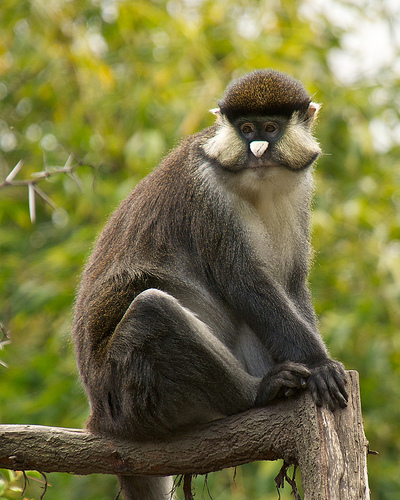

In [4]:
img = Image.open(fnames[1606]); img

We’ll be passing this input image through our VGG16 network. To do this (as we've done before), we’ll need to subtract the mean of each channel and reverse the order of RGB. 

In [5]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype = np.float32)
def preproc(x): return (x - rn_mean)[:, :, :, ::-1]
def deproc(x, s): return np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

To summarize, we took `x`, a 4D tensor of `batch_size * height * width * channel`, and subtracted it from the vector `rn_mean` using a method called **broadcasting**, which is when operations are completed on arrays of varying dimensions. 

In [6]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

The CNN we’ll be using here is VGG16 with average pooling instead of max pooling (as was used with image classification) to minimize the loss of data points. Although using average pooling will change our retrained/optimal weights, it'll give us better results. To make this change, every instance of max pooling was switched with average pooling in `vgg16.py`. 

Also, to build the architecture, we’ll be using `keras.backend`, which is an abstraction layer that allows us to use Theano and TensorFlow as backends within the same code. 

Let’s create the model object:

In [21]:
model = VGG16_Avg(include_top=False)

…and import one of the later layers of the convolutional model (we start out with `block5_conv1`, but will try `block4_conv1` later):

In [22]:
layer = model.get_layer('block5_conv1').output

The next step is to calculate the target activations at this layer. This will create a symbolic variable that contains the activation of `block5_conv1`, which is the output at conv 1 of the last/5th block. The `K` here is for Keras. It would also work if we replaced it with `tf` (for TensorFLow, because that’s the backend we’re using). 

In [23]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

Scikit-learn’s optimizers need to separately access the loss function and gradients. Here's a class for that:

In [10]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

To create the generated image, we’ll be using SGD to allow the activations of the noisy image to look more and more like that of the input. To do this, we’ll define our loss function to calculate the MSE between the two outputs at the current convolutional layer. `layer` is a symbolic object, so we’re going to need to feed it with data. Our goal is to change the input of the model to minimize our loss, so we’ll need gradients (`grads`). Then, we’ll need to create the function, `fn`, to output the loss and gradients. 

In [24]:
loss = K.mean(metrics.mse(layer, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

The last step is to run an optimizer, which would normally require us to use some type of SGD. SGD is simple, but slow. Plus, we don’t need to create random batches when we don’t have a stochastic problem to solve.  

Newton’s method is more deterministic. Instead of trying to find the gradient through asking where it is and in which direction it’s moving in so that we can take small steps towards it (because we have no idea how far we need to go to get near it), all we need to do is find out which direction we need to go in and figure out the optimum distance to near the gradient until the slope sign changes. When the sign changes, we bracket the minimum of that function and find the next minimum.

The basic idea is that of a line search. There is a SciPy module for this that we initialized in the beginning of this notebook: `fmin_1_bfgs_b`. To use it, we pass in three parameters: 

1. a function that will return a loss value at the current point. 
2. a starting point.
3. a function that will return the gradients at the current point.

In [12]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

Our starting point is going to be some random, noisy image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


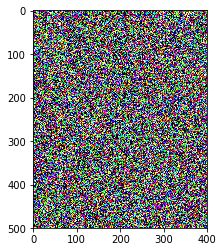

In [25]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)
x = rand_img(shp)
plt.imshow(x[0]);

Now, we'll run our optimizer over several iterationa to optimize the loss function with respect to the input image. 

In [26]:
iterations = 10

In [27]:
x = solve_image(evaluator, iterations, x)

Current loss value: 40.448360443115234


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 19.20740509033203
Current loss value: 12.611358642578125
Current loss value: 9.341225624084473
Current loss value: 7.57006311416626
Current loss value: 6.472633361816406
Current loss value: 5.708476543426514
Current loss value: 5.097328186035156
Current loss value: 4.618753433227539
Current loss value: 4.203838348388672


After 10 iterations, the noisy image has now started to resemble the input image.

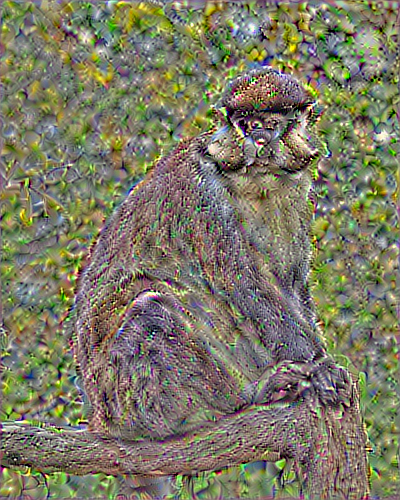

In [28]:
# using block5_conv1
Image.open(path + 'results/res_at_iteration_9.png')

Let’s instead try looking at an output from an earlier layer; instead of `block5_conv1`, we'll use`block4_conv1`. Earlier layers give less degrees of freedom to look more like another kind of input. This makes sense when you consider, at earlier layers, less transformations have been completed. The features learned are based more on geometric details rather than broad features. 

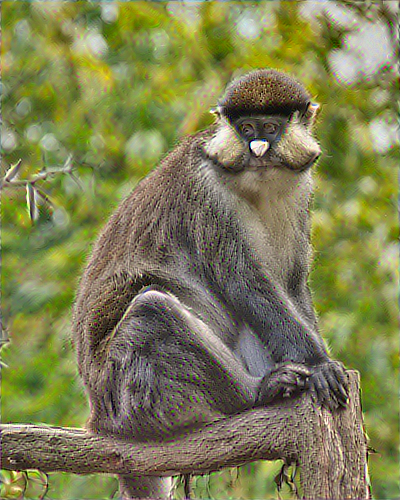

In [16]:
# using block4_conv1
Image.open(path + 'results/res_at_iteration_9.png')

## Recreating Style

We’ve learned how to recreate a content image, let’s now learn how to recreate **style**. The style of an image incorporates both its color and pattern composition. When recreating style, we don’t care about how the image is actually structured (as we did when recreating content). Instead, we like to keep the integrity of the style and use it to regenerate an image to look like the content image using features from the style.

The style image I picked is "Water Lilies", a painting by Claude Monet. 

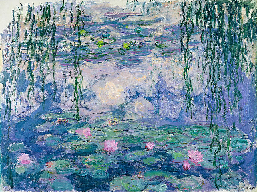

In [30]:
style = Image.open('monet.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32')); style

We’ll be using the same model architecture we used earlier with a few differences. For starters, `l_style` will be calculated differently than `l_content`. For `l_content`, we were calculating the MSE of the raw convolutional outputs. For `l_style`, we'll take the **gramian matrix** of their channels, or the dot product of the matrix with its own transpose, before taking their MSE. 

In [31]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [32]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

In [33]:
# calculate loss for multiple layers
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [34]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [35]:
def gram_matrix(x):
    # rows are channels, columns are flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

`batch_flatten` takes everything except the first dimension and flattens it into a vector. In `gram_matrix`, for every channel, we are measuring how similar its values are to other channels. The `style_loss` function will then measure how different those values are from each other. 

In [36]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

Then solve (as we’ve done before) using the same randomized image along with the Claude Monet painting:

In [37]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [38]:
rand_img = lambda shape: np.random.uniform(-50, 50, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


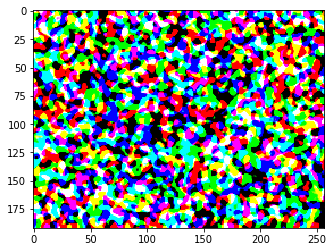

In [39]:
plt.imshow(x[0]);

In [40]:
iterations = 10
x = rand_img(shp)

In [41]:
x = solve_image(evaluator, iterations, x)

Current loss value: 1160.416259765625


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 118.59393310546875
Current loss value: 45.785865783691406
Current loss value: 25.788400650024414
Current loss value: 17.299283981323242
Current loss value: 12.67321491241455
Current loss value: 10.241706848144531
Current loss value: 7.400790214538574
Current loss value: 5.748806953430176
Current loss value: 4.670567989349365


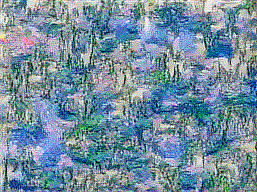

In [42]:
Image.open(path + 'results/res_at_iteration_9.png')

The generated image doesn't include any of the content from "Water Lilies", but definitely has the style of the painting (as expected). 

## Style Transfer

By transforming the convolutional outputs to the gramian, we were able to update the noisy image pixel values to generate an image that captures the raw style of the painting without any structure or content. Why is that? Nobody really knows. [Demystifying Neural Style Transfer](https://arxiv.org/pdf/1701.01036.pdf) attempts to make sense of it by explaining that neural style transfer is essentially matching feature distributions between style and generated images. 

If you’d like to keep the geometric integrity of an image, use a structured image like that of the input. This combines both of the approaches we’ve seen in this lesson. So, the obvious idea is to incorporate both of them by weighting and adding the two loss functions (`l_total` from earlier).

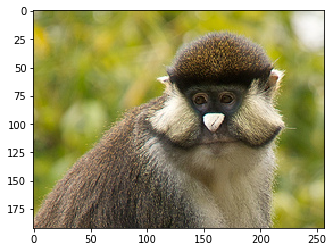

In [83]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))
    
w,h = style.size
src = img_arr[:,50:h+50,100:w+100]
plot_arr(src)

Next, we’ll need a sequence of layer outputs to compute the style loss. When choosing layers, we know that the earlier layers of our network will give an output that more closely resembles the content from the input image. By merging the content reconstruction and style, we’d expect a looser reconstruction to allow the style to show more in the output. So, choosing one of the later layers ensures that our image will look like the subject of our input image with or without the content. 

In [84]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [85]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [86]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Combining the two approaches is simple, all we have to do is merge their loss functions. So, this time, we’ll have three inputs: the content, style, and randomized/noisy image whose pixels we’re training. I've also tried using the content image instead of the randomized image (see results below). 

To adjust the reconstruction mix, we’ll need to divide the content loss by some factor (10 used here). This is something you can play around with. You’ll notice in the paper mentioned above that they also play with it. Making the number smaller will make the style more predominant in your output image. If you increase the number, the original content of the image will be overshadowed by that of the noisy image. 

In [87]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [88]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [89]:
evaluator = Evaluator(transfer_fn, shp)

In [90]:
iterations = 10
x = rand_img(shp)

In [91]:
x = solve_image(evaluator, iterations, src)

Current loss value: 1180.8251953125


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 513.0994873046875
Current loss value: 409.12493896484375
Current loss value: 365.52020263671875
Current loss value: 341.06396484375
Current loss value: 321.40362548828125
Current loss value: 307.3779602050781
Current loss value: 299.7642517089844
Current loss value: 292.35308837890625
Current loss value: 286.5862121582031


After solving, this is what you get. The monkey and background are more recognizable when using the content image as input as opposed to the randomized image.  

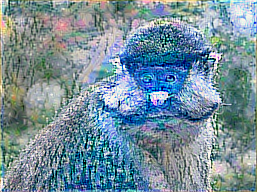

In [92]:
# using content image
Image.open(path + 'results/res_at_iteration_9.png')

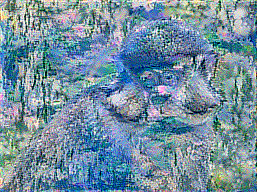

In [82]:
# using noisy image
Image.open(path + 'results/res_at_iteration_9.png')

For more examples of neural style transfer, check out this [repo](https://github.com/titu1994/Neural-Style-Transfer).